# Praca domowa 6

## Import i preprocessing danych

In [67]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_stata("hcmst.dta")

num1 = "Q34"             # Ocena jakości związku
num2 = "ppeduc"          # Najwyzszy zdobyty poziom edukacji
num3 = "Q9"              # Wiek partnera
cat1 = "Q19"             # Czy mieszkacie ze sobą obecnie?
cat2 = "Q12"             # Polityczne preferencje partnera
label = "S1"             # Czy jesteście małżeństwem

data = data[[num1,num2,cat1,cat2,num3,label]].dropna()
data.rename(columns={'Q9':'partners_age','Q34':'rel_quality','ppeduc':'education','Q19':'living_together','Q12':'partner_politics'}, inplace=True)
data.head()

,rel_quality,education,living_together,partner_politics,partners_age,S1
1,Excellent,Masters degree,Yes,Leans Republican,52,"Yes, I am Married"
2,Good,Masters degree,Yes,Leans Democrat,45,"Yes, I am Married"
4,Excellent,Bachelors degree,Yes,Strong Democrat,59,"Yes, I am Married"
5,Good,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Undecided/Independent/Other,60,"Yes, I am Married"
6,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Leans Republican,67,"Yes, I am Married"


In [68]:
from sklearn import preprocessing
    
le = preprocessing.LabelEncoder()

for column_name in data.columns:
    if column_name == "rel_quality":
        data[column_name] = data[column_name].map({
            'Refused':-1, 
            'Excellent':5, 
            "Good":4, 
            "Fair":3, 
            "Poor":2, 
            "Very poor":1
        })
    
    if column_name == "education":
        data[column_name] = data[column_name].map({
            'No formal education':1, 
            '1st, 2nd, 3rd, or 4th grade':2, 
            '5th or 6th grade':3,
            '7th or 8th grade':4,
            '9th grade':5,
            '10th grade':6,        
            '11th grade':7, 
            '12th grade no diploma':8,
            'HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)':9,
            'Some college, no degree':10,
            'Bachelors degree':11,
            'Masters degree':12,
            'Associate degree':13,
            'Professional or Doctorate degree':14
        })
        
    if column_name == 'partner_politics':
         data[column_name] = data[column_name].map({
            'Strong Republican' :1,
            'Not Strong Republican' :2,
            'Leans Republican' :3,
            'Undecided/Independent/Other' :4,
            'Leans Democrat' :5,
            'Not Strong Democrat' :6,   
            'Strong Democrat' :7
           })
    
    if column_name == 'living_together':
         data[column_name] = data[column_name].map({
            'Refused' :-1,
            'Yes' :1,
            'No' :0
         })
            
    if column_name != 'rel_quality' and column_name != 'education' and column_name != 'partner_politics' and column_name != 'living_together' and hasattr(pd.Series(data[column_name], dtype='category'), 'cat'):
        data[column_name] = le.fit_transform(data[column_name].astype(str))
             
    else:
        pass

In [69]:
from sklearn.model_selection import train_test_split

data = data.dropna()

y = data.loc[:,'S1']
X = data.loc[:, data.columns != 'S1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1851, 5), (912, 5), (1851,), (912,))

## Wyjaśniane modele

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=25)

y_pred = random_forest.fit(X_train,y_train).predict(X_test)
rf_pred_proba = random_forest.fit(X_train,y_train).predict_proba(X_test)[:,1]
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.8651315789473685


In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)

y_pred = knn.fit(X_train,y_train).predict(X_test)
knn_pred_proba = knn.fit(X_train,y_train).predict_proba(X_test)[:,1]
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.7894736842105263


## Funkcje implementujące wykresy

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM


def plot_residuals(model, ytest, ypreds):
    
    residuals = np.subtract(ytest,ypreds)
    zero_line = np.zeros(len(y_test))

    plt.scatter(ypreds,residuals, label = 'predictions')
    plt.plot(ypreds,zero_line, 'k:', label = 'y = 0')
    
    gam = LinearGAM().fit(residuals,ypreds)
    gam.gridsearch(ypreds,residuals)
    XX = gam.generate_X_grid(term=0)
    correct_values = XX > 0
    plt.plot(XX[correct_values], gam.partial_dependence(term=0, X=XX)[correct_values.flatten()],'red', label = 'trend')
    
    plt.title(type(model).__name__)
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()
    
    
    
def boxplot_residuals(model, ytest, ypreds):
    
    residuals = np.subtract(ytest,ypreds)    
    
    plt.boxplot(residuals, vert=False)
    
    plt.title(type(model).__name__)
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.show()

In [73]:
def plot_variable_residuals(model, variable, xtest, ytest, ypreds):
    
    residuals = np.subtract(ytest,ypreds)
    dep_var =  np.array(xtest[variable])
    zero_line = np.zeros(len(y_test))
    
    plt.scatter(dep_var, residuals, label='predictions')
    plt.title(type(model).__name__)
    plt.xlabel(variable)
    plt.ylabel('Residuals')
    
    gam = LinearGAM().fit(dep_var,residuals)
    gam.gridsearch(dep_var,residuals)
    XX = gam.generate_X_grid(term=0)
    correct_values = XX > 0
    plt.plot(XX[correct_values], gam.partial_dependence(term=0, X=XX)[correct_values.flatten()],'red', label = 'trend')
    plt.plot(dep_var,zero_line, 'k:', label = 'y = 0')
    plt.legend()
    plt.show()

In [74]:
def cooks_distance(model, variable, xtest, ytest, ypreds):
    
    dist = np.power(np.subtract(ytest,ypreds),2)
    
    plt.bar(xtest[variable].values,dist,width=0.2)
    
    plt.title(type(model).__name__)
    plt.xlabel(variable)
    plt.ylabel("Cook's distance")
    plt.show()

## Wykresy

### 1. Wykresy przedstawiające reszty

**Poniżej przedstawiono wykresy pokazujące zależność pomiędzy resztą (y - hat y) a wynikiem modelu (hat y). Pierwsze dwa dotyczą modelu RandomForest, drugie dwa: KNearestNeighbors**

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


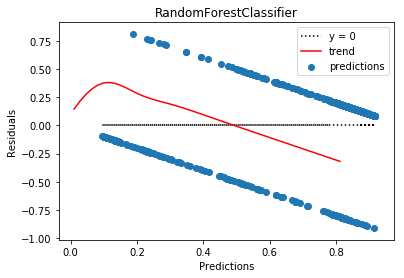

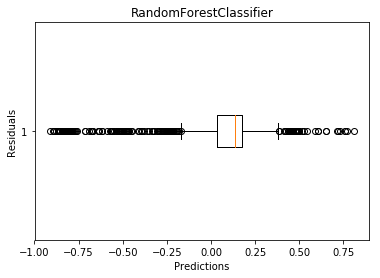

In [75]:
plot_residuals(random_forest,y_test,rf_pred_proba)
boxplot_residuals(random_forest,y_test,rf_pred_proba)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


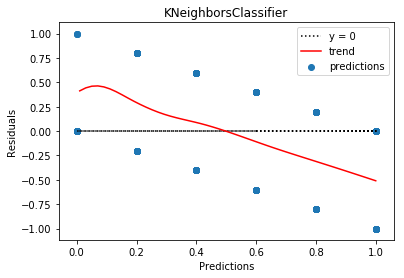

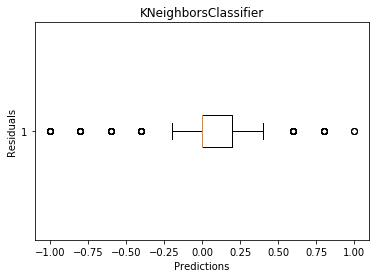

In [76]:
plot_residuals(knn,y_test,knn_pred_proba)
boxplot_residuals(knn,y_test,knn_pred_proba)

### 2. Wykresy reszt w zależności od zmiennych

**Pierwsza seria wykresów przedstawia zależności reszt od kolejno wszystkich zmiennych modelu RandomForest. Następnie przedstawiono porównanie pomiędzy modelami RandomForest oraz KNN dla zmiennej *partners_age* (wybrano tę zmienną, ponieważ ma najwięcej różnych wartości).**

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


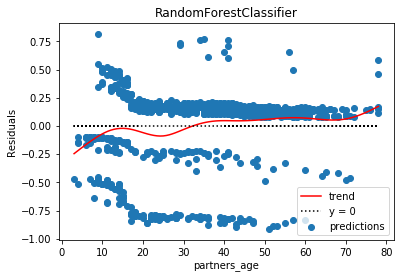

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


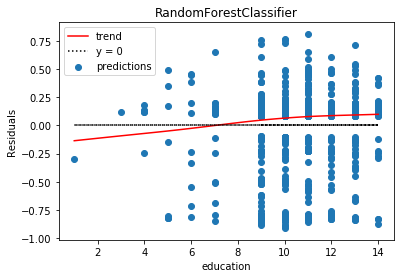

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


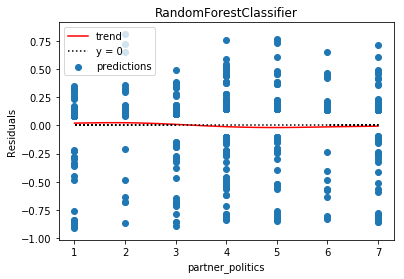

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


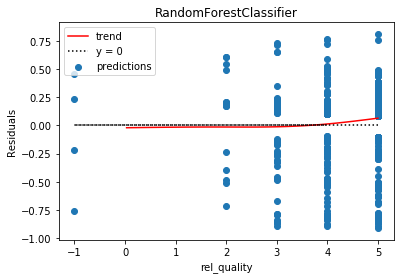

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


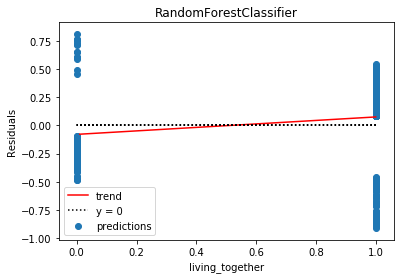

In [77]:
plot_variable_residuals(random_forest,'partners_age',X_test,y_test,rf_pred_proba)
plot_variable_residuals(random_forest,'education',X_test,y_test,rf_pred_proba)
plot_variable_residuals(random_forest,'partner_politics',X_test,y_test,rf_pred_proba)
plot_variable_residuals(random_forest,'rel_quality',X_test,y_test,rf_pred_proba)
plot_variable_residuals(random_forest,'living_together',X_test,y_test,rf_pred_proba)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


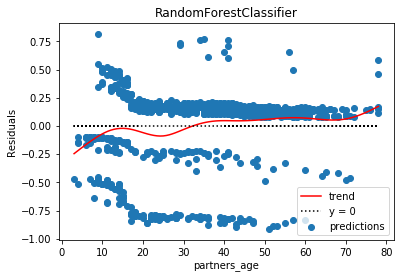

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


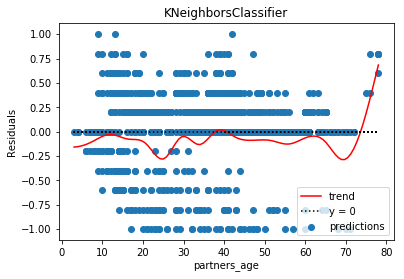

In [78]:
plot_variable_residuals(random_forest,'partners_age',X_test,y_test,rf_pred_proba)
plot_variable_residuals(knn,'partners_age',X_test,y_test,knn_pred_proba)

### 3. Wykresy odległości Cook'a

**Poniżej przestawiono wykresy odległości Cook'a w zależności od zmiennej kolejno dla wszystkich zmiennych dla obu modeli: RandomForest oraz KNN.**

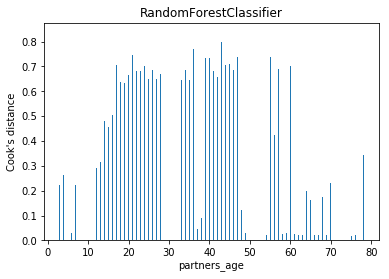

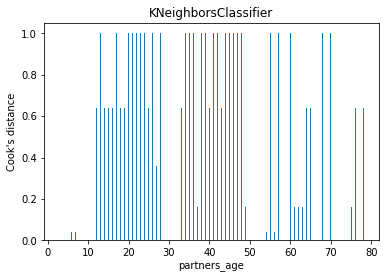

In [79]:
cooks_distance(random_forest, 'partners_age', X_test, y_test, rf_pred_proba)
cooks_distance(knn, 'partners_age', X_test, y_test, knn_pred_proba)

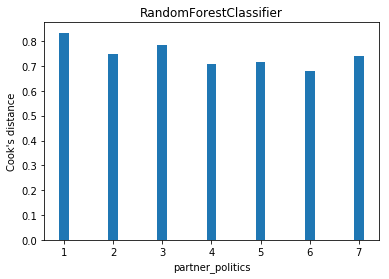

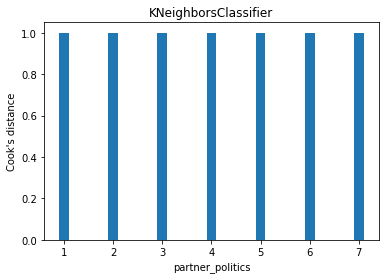

In [80]:
cooks_distance(random_forest, 'partner_politics', X_test, y_test, rf_pred_proba)
cooks_distance(knn, 'partner_politics', X_test, y_test, knn_pred_proba)

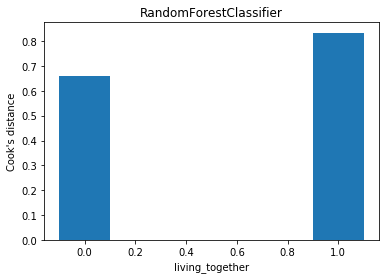

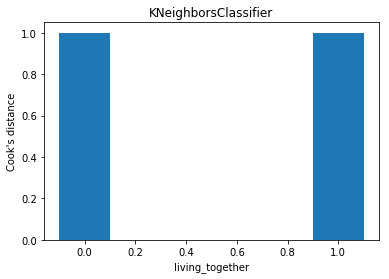

In [81]:
cooks_distance(random_forest, 'living_together', X_test, y_test, rf_pred_proba)
cooks_distance(knn, 'living_together', X_test, y_test, knn_pred_proba)

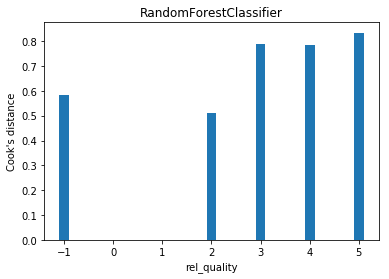

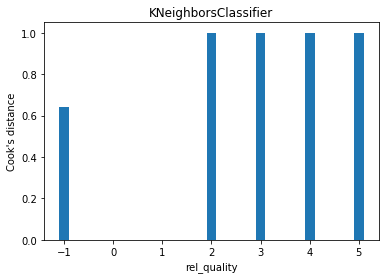

In [82]:
cooks_distance(random_forest, 'rel_quality', X_test, y_test, rf_pred_proba)
cooks_distance(knn, 'rel_quality', X_test, y_test, knn_pred_proba)

## Wnioski

1. Wykres reszt dla odpowiedzi modelu

    Wykresy trendu dla obu modeli są podobne i odbiegają od prostej y=0 - nadal są to proste, jednak odchylone od osi. Ze względu na tę swego rodzaju symetrię można stwierdzić, że model w podobnym stopniu myli się w przypadku wartości "0", co "1".

    Na wykresie typu boxplot widać, że mediana jest przesunięta nieco w stronę wartości dodatnich, czyli jeśli częściej różnica pomiędzy wartością prawdziwą a przewidywaną jest dodatnia to oznacza, że model niedoszacowuje przewidywanych wartości.


2. Wykres reszt w zależności od zmiennych

    Dla większości zmiennych wykresy nie przedstawiają się bardzo interesująco, są to prawie proste linie. Ciekawe jest jednak to, że model KNN ma bardziej zróżnicowane reszty w porównaniu do RandomForest.


3. Wykresy odległości Cook'a

    Z wykresów można odczytać, że model mniej prawdopodobnie pomyli się gdy zmienna *living_together* jest równa 0 niż wtedy, gdy jest równa 1. Podobnie przy zmiennej *partners_age*, błędy predykcji są mniejsze dla wieku powyżej 60 lat (porównując wysokości słupków, nie liczbę).

    Interesująco przestawiają się wykresy dla modelu KNN - ma on niższą dokładność niż model RandomForest, ale według wykresów (prawie) wszystkie wartości wszystkich zmiennych modelu mają odległość Cook'a równą 1?